In [89]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from itertools import product as outer
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

/Users/mfansler/anaconda/envs/bml36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("/Users/mfansler/Projects/mayrlab/projects/tmuris/coverage/peaks/result.v2.tsv", sep="\t", 
                 header=None, names=["chromosome", "position", "counts", "batch"], 
                 dtype={'chromosome': 'category', 'batch': 'category'})
df.head()

,chromosome,position,counts,batch
0,chr1,10137623,1,SRR6835855
1,chr1,10137624,1,SRR6835865
2,chr1,10137627,4,SRR6835849
3,chr1,10137627,1,SRR6835850
4,chr1,10137627,1,SRR6835856


In [3]:
bed = pd.read_csv("/Users/mfansler/Projects/mayrlab/projects/peakest/test/bed/peaks.single.partial.bed6", sep="\t", 
                  header=None, names=["chromosome", "start", "stop", "gene", "score", "strand"],
                  dtype={'chromosome': 'category', 'gene': 'category', 'strand': 'category'})
bed['txEnd'] = bed.apply(lambda df: df.stop if df.strand == '+' else df.start, axis=1)
bed['width'] = np.abs(bed.start - bed.stop)
bed.head()

,chromosome,start,stop,gene,score,strand,txEnd,width
0,chr1,10137565,10138306,Arfgef1,0,-,10137565,741
1,chr1,54987021,54987497,Sf3b1,0,-,54987021,476
2,chr1,171340791,171341636,Dedd,0,+,171341636,845
3,chr10,52337021,52338132,Gopc,0,-,52337021,1111
4,chr10,77597639,77598741,Pttg1ip,0,+,77598741,1102


## Annotate with Gene Symbol

In [7]:
def intersect_gene(rec):
    annot = bed.loc[bed.chromosome == rec.chromosome, :]
    annot = annot.loc[(annot.start <= rec.position) & (annot.stop >= rec.position), 'gene']
    if len(annot) > 1:
        print("[WARNING]: Ambiguous annotation! Found %d matching genes." % len(annot))
    return annot[0]

df['gene'] = df.apply(intersect_gene, axis=1)
df.head()

,chromosome,position,counts,batch,gene
0,chr1,10137623,1,SRR6835855,Arfgef1
1,chr1,10137624,1,SRR6835865,Arfgef1
2,chr1,10137627,4,SRR6835849,Arfgef1
3,chr1,10137627,1,SRR6835850,Arfgef1
4,chr1,10137627,1,SRR6835856,Arfgef1


## Augment with peak info and convert genomic position to transcript end distance

In [8]:
df2 = pd.merge(df, bed.loc[:,["gene", "txEnd", "width"]], on='gene')
df2['distance'] = np.abs(df2.position - df2.txEnd)

data = df2.loc[df2.distance <= df2.width, :].sort_values(by=['gene', 'batch'])

# How many out of range?
print(np.sum(df2.distance > df2.width))

0


In [9]:
data.head()

,chromosome,position,counts,batch,gene,txEnd,width,distance
257533,chr2,91278316,1,SRR6835844,1110051M20Rik,91278241,711,75
257538,chr2,91278318,1,SRR6835844,1110051M20Rik,91278241,711,77
257565,chr2,91278323,1,SRR6835844,1110051M20Rik,91278241,711,82
257570,chr2,91278324,1,SRR6835844,1110051M20Rik,91278241,711,83
257608,chr2,91278328,1,SRR6835844,1110051M20Rik,91278241,711,87


In [60]:
data.to_csv("/Users/mfansler/Projects/mayrlab/projects/tmuris/coverage/peaks/tmuris.coverage.partial.tsv.gz",
            sep='\t', index=False, compression='gzip')

In [10]:
data.batch.unique()

[SRR6835844, SRR6835845, SRR6835846, SRR6835847, SRR6835848, ..., SRR6835867, SRR6835868, SRR6835869, SRR6835870, SRR6835871]
Length: 28
Categories (28, object): [SRR6835844, SRR6835845, SRR6835846, SRR6835847, ..., SRR6835868, SRR6835869, SRR6835870, SRR6835871]

In [181]:
rundata = pd.read_csv("/Users/mfansler/Projects/mayrlab/projects/tmuris/GSE109774_metadata.10x.txt",
                      sep='\t', usecols=['Run', 'tissue'])
rundata.set_index('Run', inplace=True)

rundata.head()

,tissue
Run,
SRR6835844,Tongue
SRR6835845,Tongue
SRR6835846,Liver
SRR6835847,Bladder
SRR6835848,Bladder


In [12]:
data.gene.unique()

array(['1110051M20Rik', 'Acaca', 'Agl', 'Aplp2', 'Arfgef1', 'Asb6',
       'BC037034', 'Bcas3', 'Bcl2l1', 'C2cd2l', 'Calm3', 'Ccdc92',
       'Cd151', 'Cd2bp2', 'Chd3', 'Chmp3', 'Clip2', 'Cog6', 'Cstf1',
       'Dedd', 'Dnm2', 'Dpm2', 'Entpd6', 'Eral1', 'Fam193a', 'Fbxw8',
       'Fitm2', 'Fnip1', 'Gabarapl1', 'Gnb1', 'Golga2', 'Gopc', 'Hadh',
       'Kat7', 'Kxd1', 'Lrpap1', 'Lrrc59', 'Lyrm2', 'Map1lc3b', 'Mau2',
       'Metap1', 'Mllt11', 'Nab2', 'Nckap1', 'Ncln', 'Ncor2', 'Ndrg3',
       'Ntmt1', 'Otud4', 'Pcbp4', 'Pgap2', 'Pgd', 'Prosc', 'Ptges2',
       'Pttg1ip', 'Pxn', 'Rapgef6', 'Rbm39', 'Rusc2', 'Sec61a1', 'Sep15',
       'Sf3b1', 'Sh2b1', 'Sh2b3', 'Snapc2', 'Snx21', 'Srpk2', 'Stard7',
       'Tbc1d10a', 'Tmed1', 'Tmub1', 'Tmx2', 'Traf2', 'Trappc3', 'Ttbk2',
       'Ube2z', 'Ube3b', 'Ubqln4', 'Vamp2', 'Vamp3', 'Vps9d1', 'Wdr5',
       'Ywhah', 'Zfp444', 'Zfp64'], dtype=object)

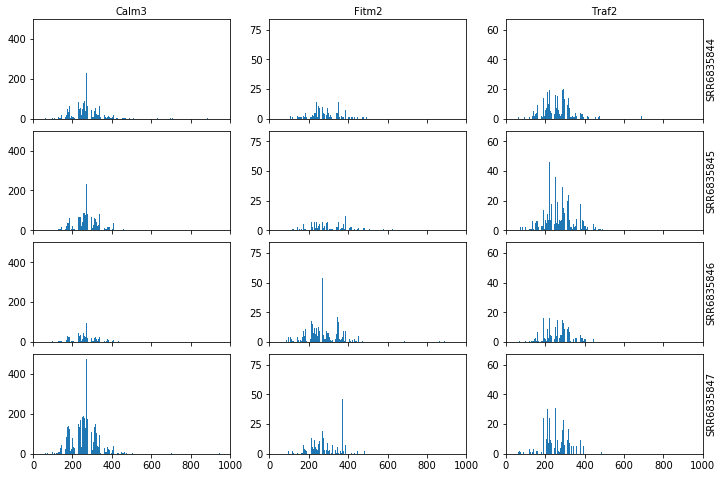

In [228]:
genes = ['Calm3', 'Fitm2', 'Traf2']
batches = ['SRR6835844', 'SRR6835845', 'SRR6835846', 'SRR6835847']
B, G = len(batches), len(genes)

f, axs = plt.subplots(B, G, figsize=(12, 8), sharex='all', sharey='col')
axs[0,0].set_xlim(left=0, right=1000)

for (i,j) in outer(range(B), range(G)):
    b, g = batches[i], genes[j]
    d_gb = data.loc[(data.gene == g) & (data.batch == b), :]
    axs[i, j].bar(x=d_gb.distance, height=d_gb.counts)
    if i == 0:
        axs[i,j].set(xlabel=g)
        axs[i,j].xaxis.set_label_position("top")

    if j == G - 1:
        axs[i,j].set(ylabel=b)
        axs[i,j].yaxis.set_label_position("right")
        

f.subplots_adjust(hspace=0.12)
plt.show()

# Modeling

In [ ]:
G = data.gene.nunique()
B = data.batch.nunique()

X = pd.get_dummies(data.loc[:, ['gene', 'batch']]).values.astype(np.float)
X_aug = np.concatenate((np.ones((len(data),1)), X), axis=1)
Y = data.distance.values.astype(np.float)
W = data.counts.values.astype(np.float)

In [54]:
data_agg = data.groupby(['batch', 'distance']).agg({'counts': 'sum'})

X_agg = pd.get_dummies(data_agg.index.get_level_values('batch').values)
Y_agg = data_agg.index.get_level_values('distance').values.astype(np.float)
W_agg = data_agg.counts.values.astype(np.float)

data_agg.head()

counts
batch      distance        
SRR6835844 59             3
           60             1
           61             9
           62             6
           63            23

In [56]:
with pm.Model() as m1:
    sigma_all = pm.Normal('sigma_all', mu=50, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X_agg.shape[1])
    mu_all = pm.Normal('mu_all', mu=300, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X_agg.shape[1])
    
    sigma = sigma_all + pm.math.dot(X_agg, alpha)
    mu = mu_all + pm.math.dot(X_agg, beta)
    
    y = pm.Potential('y_logp_weighted', W_agg*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y_agg))
    
    trace_m1 = pm.sample(10000, tune=10000, chains=4, cores=4, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [mu_all]
>Metropolis: [alpha]
>Metropolis: [sigma_all]
Sampling 4 chains: 100%|██████████| 80000/80000 [23:46<00:00, 56.09draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [57]:
pm.summary(trace_m1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma_all,81.546668,0.886174,0.088589,8.019019e+01,82.405618,2.003214,28.074458
mu_all,272.624195,0.195624,0.019082,2.722441e+02,272.937771,5.172471,1.486640
beta__0,-1.611232,0.513347,0.050262,-2.508075e+00,-0.758537,2.236516,3.403971
beta__1,3.046175,0.493907,0.048351,2.161560e+00,3.845707,2.245628,3.364167
beta__2,-9.895107,0.243308,0.020942,-1.030630e+01,-9.361576,8.082183,1.278317
beta__3,-11.339922,0.519327,0.051046,-1.228515e+01,-10.544629,2.207309,3.653613
beta__4,-8.007809,0.512161,0.050198,-8.933451e+00,-7.209446,2.228369,3.464362
beta__5,-13.446497,0.531242,0.052145,-1.449331e+01,-12.700422,2.226129,3.494799
beta__6,-13.919109,0.328650,0.030776,-1.450993e+01,-13.264016,2.971822,1.939232
beta__7,-18.326593,0.526880,0.051636,-1.926469e+01,-17.491914,2.235722,3.428122


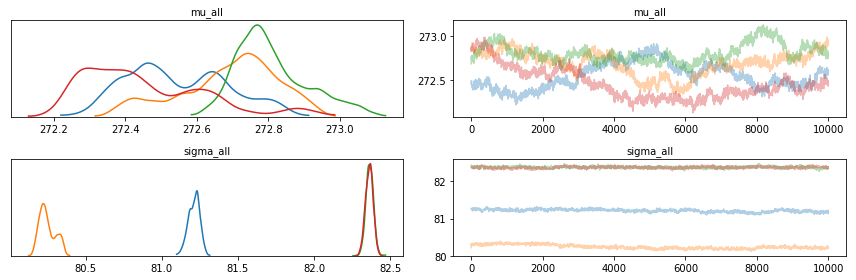

In [58]:
az.plot_trace(trace_m1, var_names=['mu_all', 'sigma_all'])
plt.show()

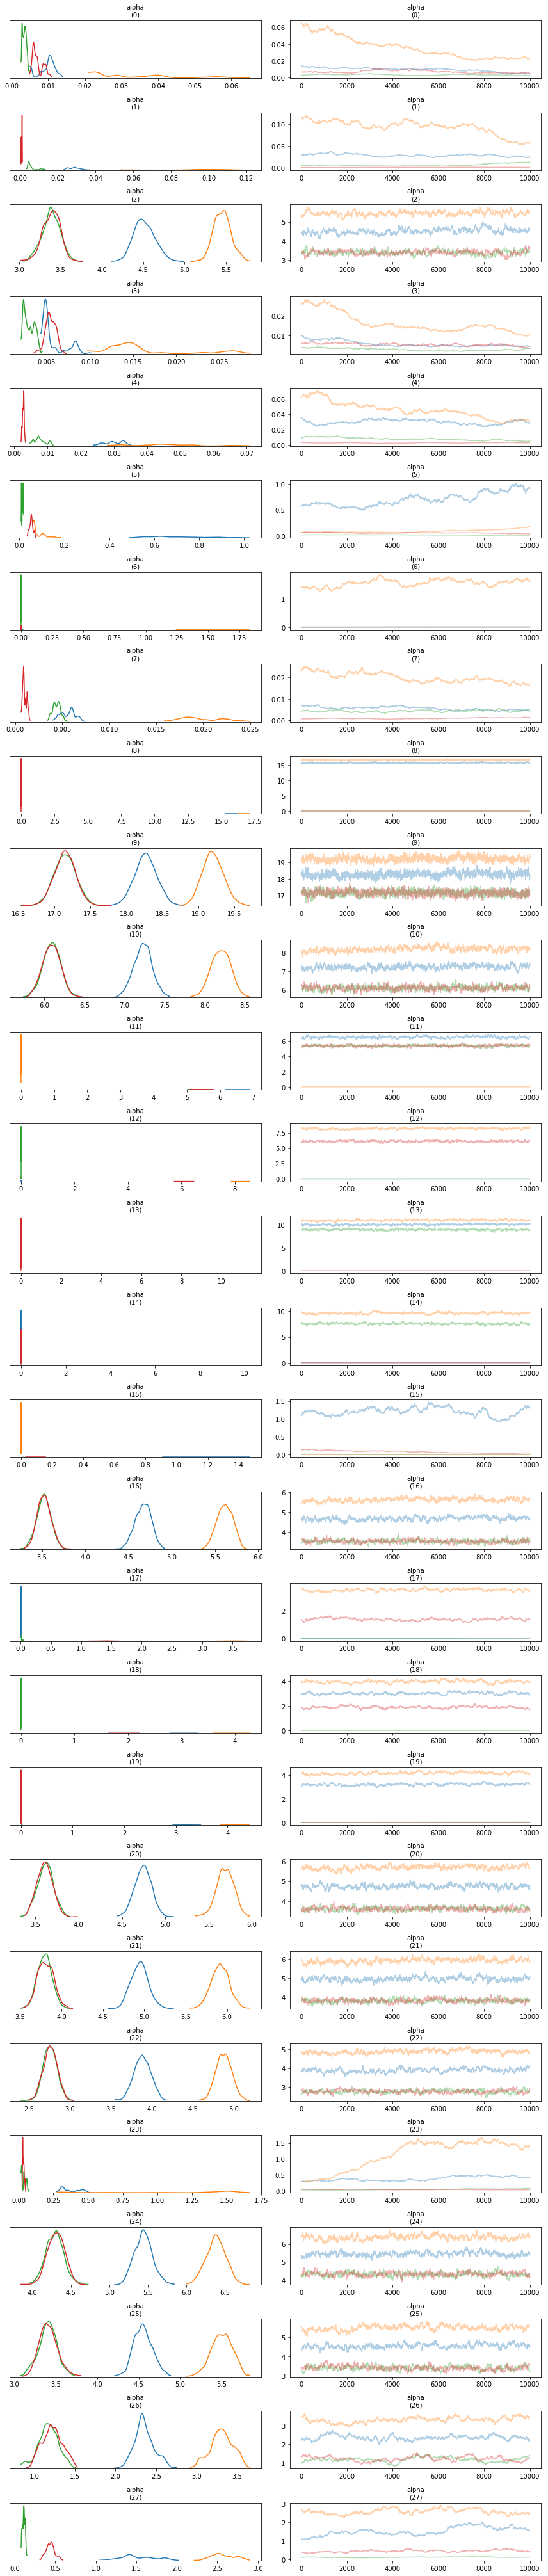

In [61]:
az.plot_trace(trace_m1, var_names=['alpha'])
plt.show()

# Model 2
## MAP Fit

In [74]:
with pm.Model() as m2:
    sigma_all = pm.Normal('sigma_all', mu=70, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X_agg.shape[1])
    mu_all = pm.Normal('mu_all', mu=300, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X_agg.shape[1])
    
    sigma = sigma_all + pm.math.dot(X_agg, alpha)
    mu = mu_all + pm.math.dot(X_agg, beta)
    
    y = pm.Potential('y_logp_weighted', W_agg*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y_agg))
    
    map_m2 = pm.find_MAP()

logp = -6.9667e+07, ||grad|| = 151.37: 100%|██████████| 150/150 [00:01<00:00, 78.80it/s]   


In [75]:
map_m2

{'alpha': array([9.41555357e-03, 2.29017682e-02, 7.22180648e+00, 4.62792288e-03,
        1.59513522e-02, 3.52855292e+00, 3.34171567e+00, 8.53598259e-03,
        1.84808632e+01, 2.09496340e+01, 9.94583775e+00, 9.24003669e+00,
        9.95647759e+00, 1.27332225e+01, 1.13990739e+01, 3.87886963e+00,
        7.39885057e+00, 5.29025794e+00, 5.73880846e+00, 5.91903193e+00,
        7.46586212e+00, 7.66980619e+00, 6.63552121e+00, 3.21734713e+00,
        8.15772954e+00, 7.26397894e+00, 5.05138585e+00, 4.26517052e+00]),
 'alpha_log__': array([-4.66539232, -3.77654116,  1.97710513, -5.37564713, -4.13821167,
         1.26088785,  1.20648435, -4.7634648 ,  2.91673578,  3.04212118,
         2.29715415,  2.22354586,  2.29822335,  2.54421453,  2.43353212,
         1.35554378,  2.00132466,  1.665867  ,  1.7472516 ,  1.77817291,
         2.01034091,  2.03729135,  1.89243722,  1.16855715,  2.09896589,
         1.98292774,  1.61966263,  1.45048216]),
 'beta': array([ -4.05323766,   0.56808876, -10.84593724

In [130]:
def gamma_reparam(mu, sd):
    alpha = mu**2/sd**2
    scale  = sd**2/mu

    return alpha, scale

In [136]:
coef_names = pd.get_dummies(data.loc[:,'batch']).columns.values
coef_names

[SRR6835844, SRR6835845, SRR6835846, SRR6835847, SRR6835848, ..., SRR6835867, SRR6835868, SRR6835869, SRR6835870, SRR6835871]
Length: 28
Categories (28, object): [SRR6835844, SRR6835845, SRR6835846, SRR6835847, ..., SRR6835868, SRR6835869, SRR6835870, SRR6835871]

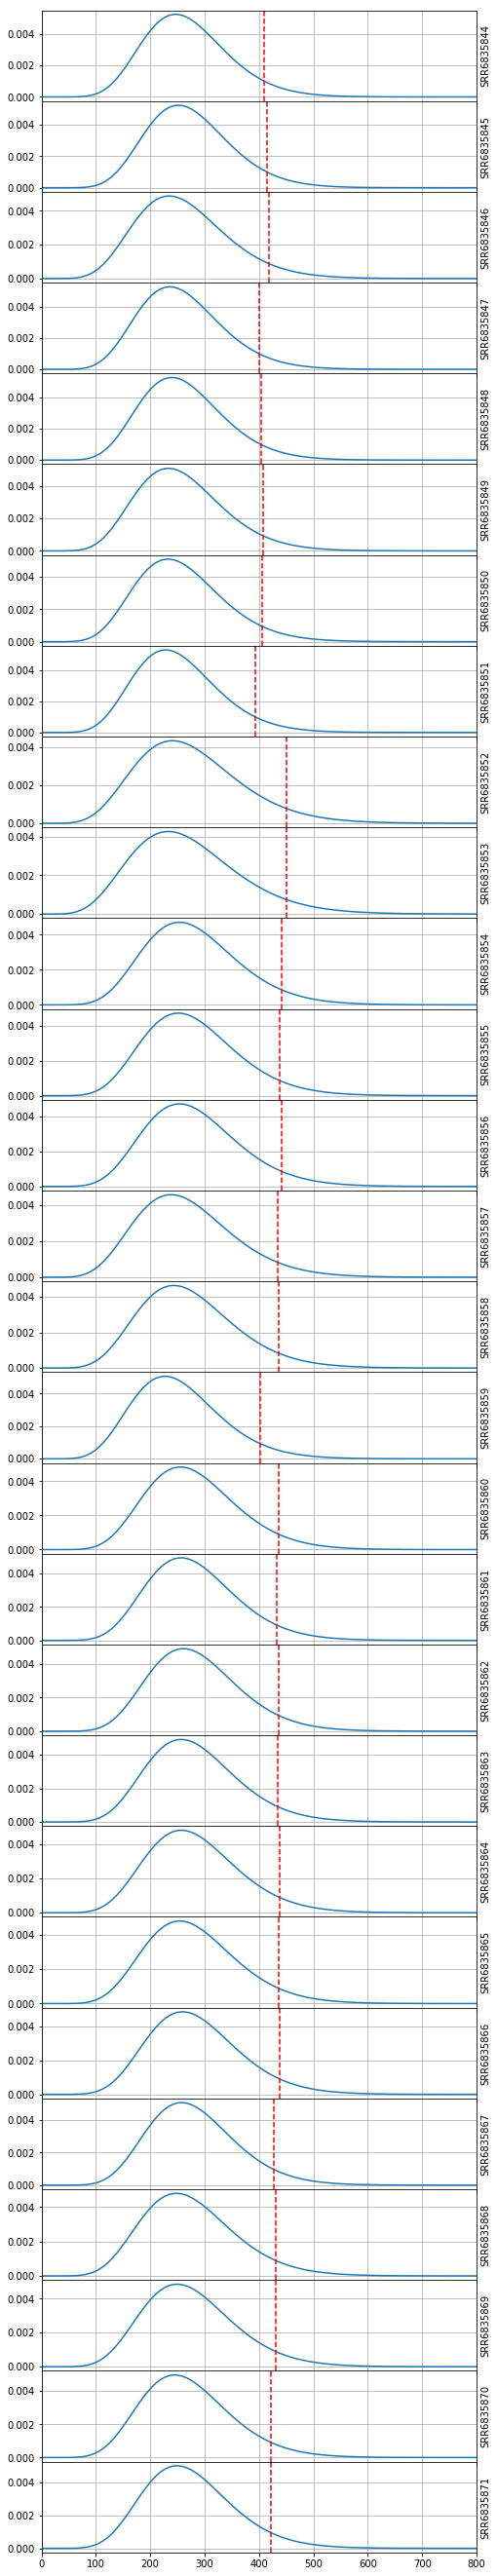

In [142]:
N = len(map_m2['alpha'])
X_plt = np.linspace(1, 800, num=100)
mu_all_hat = map_m2['mu_all']
sigma_all_hat = map_m2['sigma_all']

f, axs = plt.subplots(N, sharex=True, figsize=(8,48))
f.subplots_adjust(hspace=0)
axs[0].set_xlim(left=0, right=800)

for i in range(N):
    a, scale = gamma_reparam(mu_all_hat + map_m2['beta'][i], sigma_all_hat + map_m2['alpha'][i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(x=X_plt)
    axs[i].plot(X_plt, Y_plt)
    axs[i].grid(True)
    axs[i].set(ylabel=coef_names[i])
    axs[i].yaxis.set_label_position("right")
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
plt.show()

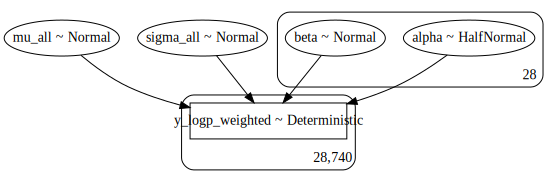

In [90]:
pm.model_to_graphviz(m2)

# Model 3
## GLM (shared dispersion)

In [91]:
gamma_model = sm.GLM(Y, X_aug, freq_weights=W, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

/Users/mfansler/anaconda/envs/bml36/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                803934
Model:                            GLM   Df Residuals:                  11968294
Model Family:                   Gamma   Df Model:                           111
Link Function:          inverse_power   Scale:              0.09904063553261062
Method:                          IRLS   Log-Likelihood:             -6.9625e+07
Date:                Mon, 26 Nov 2018   Deviance:                    1.1487e+06
Time:                        21:43:34   Pearson chi2:                  1.19e+06
No. Iterations:                   100                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.977e+07   4.91e+07      1.217      0.223   -3.65e+07    1.56e+08
x1          -1.59e+07   1.31e+07     -1.217

Looks like it didn't converge!

# Model 4
## Full MAP Fit

In [92]:
with pm.Model() as full_map_model:
    sigma_all = pm.Normal('sigma_all', mu=70, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X.shape[1])
    mu_all = pm.Normal('mu_all', mu=300, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X.shape[1])
    
    sigma = sigma_all + pm.math.dot(X, alpha)
    mu = mu_all + pm.math.dot(X, beta)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    map_full_map = pm.find_MAP()

logp = -6.9529e+07, ||grad|| = 68.447: 100%|██████████| 456/456 [03:50<00:00,  1.98it/s]    


In [225]:
for k, v in map_full_map.items():
    print("%s: %s | mean = %f | median = %f" % (k, v.shape, np.mean(v), np.median(v)))

sigma_all: () | mean = 72.752437 | median = 72.752437
alpha_log__: (113,) | mean = 0.413767 | median = 1.506532
mu_all: () | mean = 274.097063 | median = 274.097063
beta: (113,) | mean = -0.137127 | median = -1.574478
alpha: (113,) | mean = 6.396014 | median = 4.511059


In [96]:
map_full_map

{'alpha': array([1.49624019e+00, 1.62654414e+01, 4.16476194e+01, 1.96985005e+00,
        3.54499653e+00, 3.40347412e-02, 4.93902427e+00, 1.33354007e-01,
        1.23114113e+01, 1.40609710e+00, 2.75206733e-04, 9.67705857e+00,
        9.12929750e+00, 5.22709001e+00, 1.46321369e+00, 4.88263478e+00,
        1.17167590e-01, 4.17922947e+00, 1.22750219e+00, 1.18065242e+01,
        4.93905446e+00, 2.28086561e+00, 1.89730018e+00, 1.57780386e-01,
        1.44080457e+01, 2.26346333e+01, 1.36509622e+01, 8.11464680e+00,
        4.95457440e-02, 6.88658258e+00, 3.53239144e+00, 1.25767201e+01,
        3.48865790e+01, 2.40248458e+01, 1.63148010e-03, 2.48425310e+00,
        3.80105408e+00, 1.31229982e-02, 3.15309243e-04, 1.07793167e+01,
        5.97605979e+00, 3.43802496e+00, 2.17064993e+00, 1.60017703e+00,
        6.28091455e+00, 4.88328234e+00, 1.84078442e+00, 2.68004569e+00,
        2.21235657e+01, 2.70672481e+00, 2.72174442e+01, 2.89469113e+00,
        9.34167046e+00, 1.22558833e+00, 7.79066413e+00,

In [112]:
coef_names = pd.get_dummies(data.loc[:,['batch', 'gene']]).columns.values
batch_names = coef_names[:28]
gene_names = coef_names[28:]

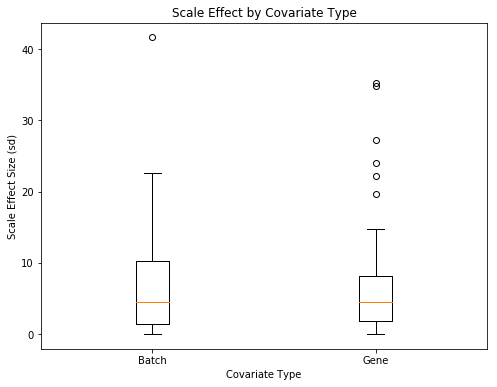

In [144]:
plt.figure(figsize=(8,6))
plt.boxplot([map_full_map['alpha'][:28], map_full_map['alpha'][28:]], labels=['Batch', 'Gene'])
plt.title("Scale Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Scale Effect Size (sd)")
plt.show()

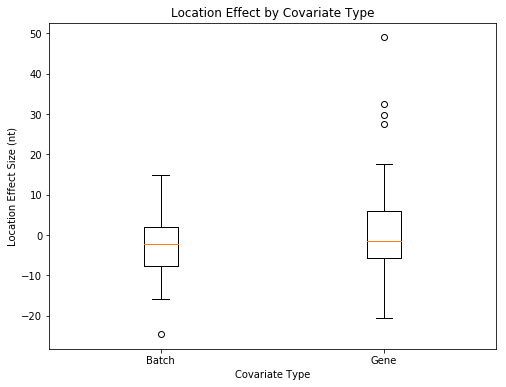

In [145]:
plt.figure(figsize=(8,6))
plt.boxplot([map_full_map['beta'][:28], map_full_map['beta'][28:]], labels=['Batch', 'Gene'])
plt.title("Location Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

In [146]:
map_m2['beta']

array([ -4.05323766,   0.56808876, -10.84593724, -13.94287777,
       -10.52891301, -14.20573264, -14.90999068, -20.87992452,
         1.40413346,  -3.71735524,   7.84678894,   5.64945443,
         7.97265798,  -4.41128844,  -0.65428401, -19.78604663,
         8.00476657,   7.98728126,  12.20726086,   8.6759955 ,
         9.53609278,   7.02065617,  11.22144531,   7.61452891,
         1.78087474,   2.43540477,  -2.787467  ,   0.43955015])

In [147]:
cutoff_95 = np.empty((28, 85))

a_all = map_full_map['sigma_all']
b_all = map_full_map['mu_all']

for i in range(28):
    a_i, b_i = map_full_map['alpha'][i], map_full_map['beta'][i]
    
    for j in range(85):
        a_j, b_j = map_full_map['alpha'][28 + j], map_full_map['beta'][28 + j]
        a, scale = gamma_reparam(b_all + b_i + b_j, a_all + a_i + a_j)
        
        cutoff_95[i, j] = stats.gamma(a=a, scale=scale).isf(0.05)


In [189]:
rundata.tissue.unique()

array(['Tongue', 'Liver', 'Bladder', 'Kidney', 'Spleen', 'Marrow',
       'Heart', 'Lung', 'Thymus', 'Mammary', 'Muscle', 'Trachea'],
      dtype=object)

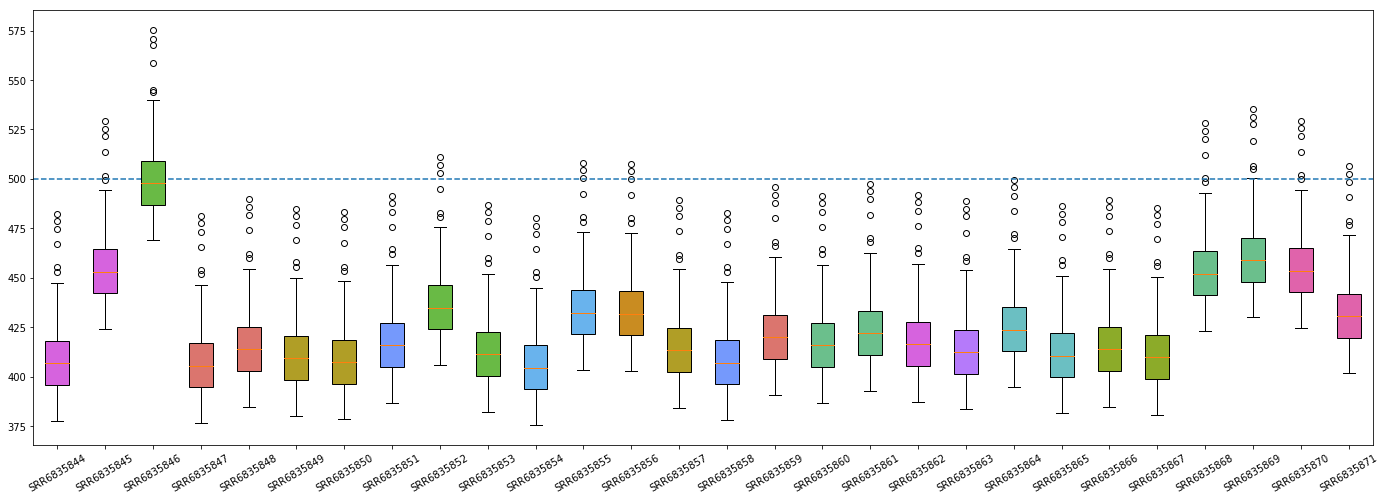

In [190]:
colmap = {
    'Bladder': (0.86, 0.46, 0.43),
    'Heart': (0.79, 0.55, 0.13),
    'Kidney': (0.69, 0.62, 0.15),
    'Muscle': (0.55, 0.67, 0.16),
    'Liver': (0.41, 0.73, 0.27),
    'Lung': (0.42, 0.75, 0.55),
    'Mammary': (0.42, 0.75, 0.76),
    'Marrow': (0.41, 0.70, 0.93),
    'Spleen': (0.46, 0.60, 0.99),
    'Thymus': (0.71, 0.48, 0.98),
    'Tongue': (0.84, 0.39, 0.87),
    'Trachea': (0.88, 0.39, 0.67)
}

coef_names = pd.get_dummies(data.loc[:,'batch']).columns.values
coef_names

plt.figure(figsize=(24,8))
bxp = plt.boxplot(cutoff_95.T, labels=coef_names, patch_artist=True)
for i, bxs in enumerate(bxp['boxes']):
    bxs.set_facecolor(colmap[rundata.tissue[coef_names[i]]])
plt.xticks(rotation=30)

plt.axhline(500, linestyle='--')

plt.show()

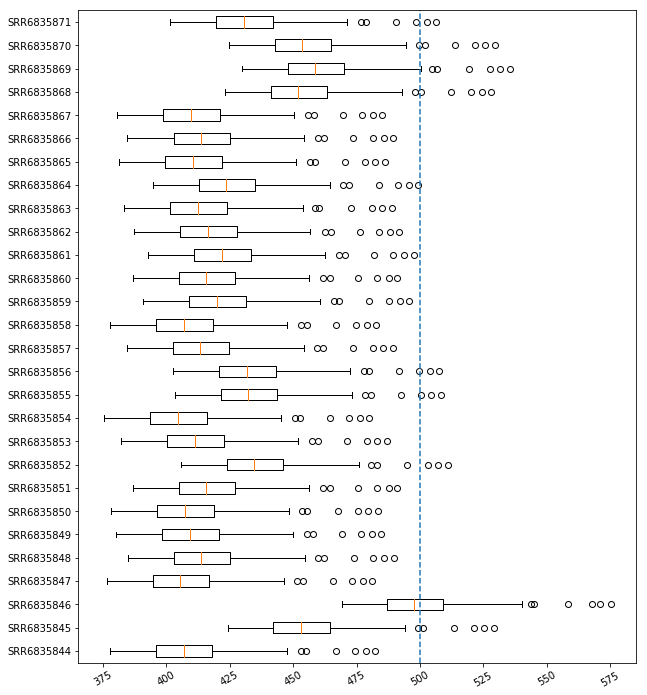

In [205]:
plt.figure(figsize=(10,12))
plt.boxplot(cutoff_95.T, labels=coef_names, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

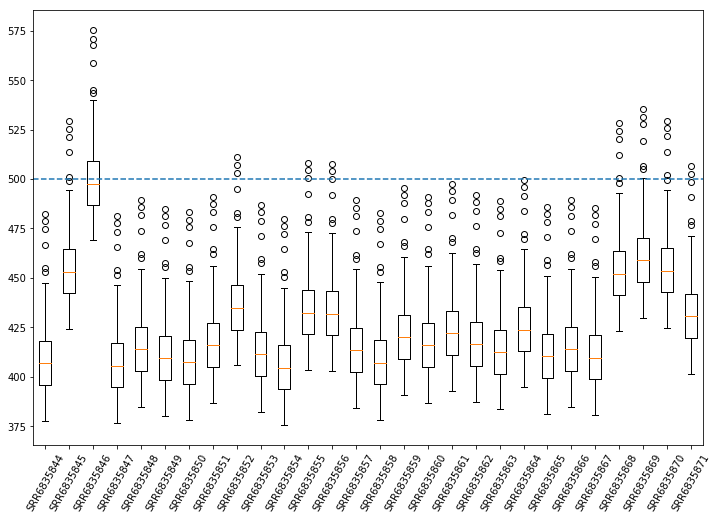

In [207]:
plt.figure(figsize=(12,8))
plt.boxplot(cutoff_95.T, labels=coef_names)
plt.xticks(rotation=60)

plt.axhline(500, linestyle='--')

plt.show()

In [158]:
cutoff_95.mean(axis=1)

array([410.02452801, 456.42490475, 501.22300288, 408.74823173,
       417.08533593, 412.4574153 , 410.58177748, 418.99423069,
       438.02676634, 414.53473004, 407.66171433, 435.56673336,
       434.99081233, 416.6058206 , 410.21917286, 423.14434148,
       419.01431878, 425.11022448, 419.51105836, 415.714907  ,
       426.95984421, 413.63266382, 416.97863226, 412.90854157,
       455.36258179, 462.15932151, 456.85306005, 433.84551524])

In [160]:
coef_names

[SRR6835844, SRR6835845, SRR6835846, SRR6835847, SRR6835848, ..., SRR6835867, SRR6835868, SRR6835869, SRR6835870, SRR6835871]
Length: 28
Categories (28, object): [SRR6835844, SRR6835845, SRR6835846, SRR6835847, ..., SRR6835868, SRR6835869, SRR6835870, SRR6835871]

# Aggregating Gamma RVs

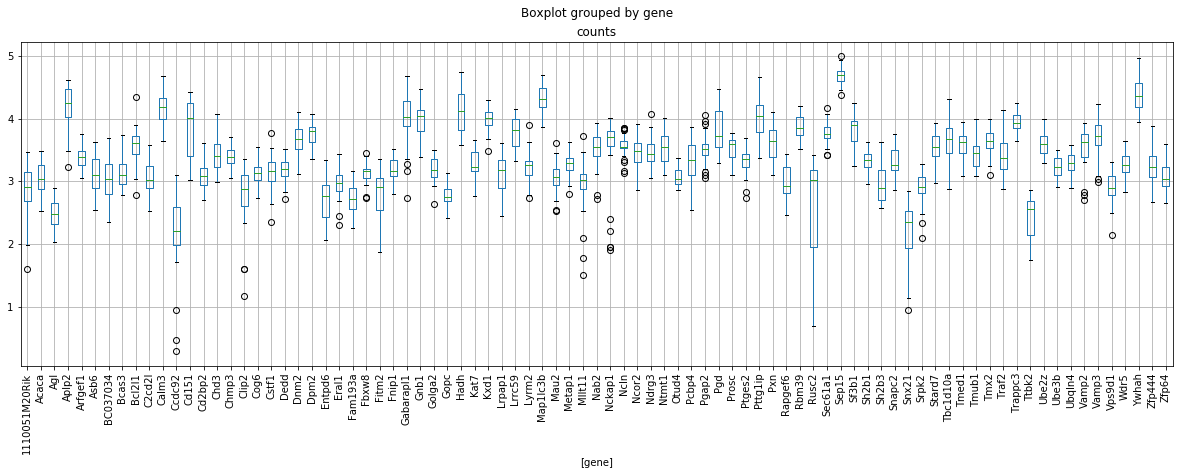

In [319]:
np.log10(data.loc[:,['gene', 'batch', 'counts']].groupby(['gene', 'batch']).sum()).boxplot(by='gene', figsize=(20,6))
plt.xticks(rotation=90)
plt.show()

In [384]:
np.random.seed(2018)

mu1, sd1 = 300, 100
mu2, sd2 = 350, 100

a1, scale1 = gamma_reparam(mu=mu1, sd=sd1)
a2, scale2 = gamma_reparam(mu=mu2, sd=sd2)

cutoff1 = stats.gamma(a=a1, scale=scale1).isf(0.05)
cutoff2 = stats.gamma(a=a2, scale=scale2).isf(0.05)

print("95%% cutoff 1 = %0.2f; 95%% cutoff 2 = %0.2f" % (cutoff1, cutoff2))

num_tests = 10000
loc_counts = np.empty(num_tests, dtype=np.int64)

for i in range(num_tests):
    y1 = stats.gamma(a=a1, scale=scale1).rvs(np.random.randint(50,1000))
    y2 = stats.gamma(a=a2, scale=scale2).rvs(np.random.randint(50,1000))
    
    a_12, loc_12, scale_12 = stats.gamma.fit(np.concatenate([y1,y2]), floc=0)
    cutoff_12 = stats.gamma(a=a_12, scale=scale_12, loc=loc_12).isf(0.05)
    
    loc_counts[i] = 1 if cutoff_12 > cutoff2 else -1 if cutoff_12 < cutoff1 else 0
    
tally = np.unique(loc_counts, return_counts=True)[1]

fmtstr = "Found %0.2f%% with lower, %0.2f%% with intermediate, and %0.2f%% with higher 95%% cutoffs."
print(fmtstr % tuple(100*tally/num_tests))

95% cutoff 1 = 481.15; 95% cutoff 2 = 529.06
Found 0.96% with lower, 92.70% with intermediate, and 6.34% with higher 95% cutoffs.


I am trying to figure out why the 95% survival locations are so drastically different between the aggregated model and the full model.  Not only do none of the aggregated fits predict 95% cutoffs above 450 nt, but the batch effects do not correspond with one another.  Initially, I thought that perhaps the different expression levels of genes in different samples might explain the difference, but looking at sample SRR6835846 the cutoff locations for all the genes are above the level that occurs in the aggregated data.  The above test shows that if the input RV's (per gene) are gamma distributed, then aggregating them should yield a fitted gamma that has summary stats between the input extremes 98.67% of the time, with 1.14% higher 95% cutoff and 0.19% lower cutoff.

This leads me to believe that this effect, of the aggregated data being far below the inputs, results from the inputs not actually being gamma distributed, and the predicted 95% cutoffs are not reliable.